# Poisson分布モデル

* 黒木玄
* 2022-10-08
$
\newcommand\op{\operatorname}
\newcommand\kbar{{\bar k}}
\newcommand\lambdahat{{\hat\lambda}}
\newcommand\pvalue{\op{pvalue}}
\newcommand\cdf{\op{cdf}}
\newcommand\ccdf{\op{ccdf}}
\newcommand\quantile{\op{quantile}}
$

<h1>目次<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Poisson分布モデル" data-toc-modified-id="Poisson分布モデル-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Poisson分布モデル</a></span><ul class="toc-item"><li><span><a href="#対数尤度比検定のP値" data-toc-modified-id="対数尤度比検定のP値-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>対数尤度比検定のP値</a></span></li><li><span><a href="#Bayes因子" data-toc-modified-id="Bayes因子-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Bayes因子</a></span></li><li><span><a href="#対数尤度比とBayes因子の関係" data-toc-modified-id="対数尤度比とBayes因子の関係-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>対数尤度比とBayes因子の関係</a></span></li><li><span><a href="#対数尤度比検定のP値とBayes因子の関係" data-toc-modified-id="対数尤度比検定のP値とBayes因子の関係-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>対数尤度比検定のP値とBayes因子の関係</a></span></li><li><span><a href="#数値的な確認" data-toc-modified-id="数値的な確認-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>数値的な確認</a></span></li></ul></li></ul></div>

In [1]:
using Distributions
using Random
using SpecialFunctions
using StatsBase: ecdf
using StatsPlots
default(fmt=:png, titlefontsize=10, plot_titlefontsize=10, guidefontsize=9)

## Poisson分布モデル

### 対数尤度比検定のP値

__データの数値:__ データの数値は $n$ 個の0以上の整数 $k=(k_1,\ldots,k_n)$ で構成されているとする.

__標本平均:__ $\kbar = \frac{1}{n}\sum_{i=1}^n k_i$ とおく.

__統計モデル1:__ パラメータ $\lambda > 0$ を持つ統計モデル1を次のように定める:

$$
P(k|\lambda) = \prod_{i=1}^n \frac{e^{-\lambda}\lambda^{k_i}}{k_i!} =
\frac{e^{-n\lambda}\lambda^{n\kbar}}{k_1!\cdots k_n!}.
$$

__統計モデル1での最尤推定:__ 与えられたデータの数値 $k=(k_1,\ldots,k_n)$ について, $P(k|\lambda)$ を最大化する $\lambda$ は $\lambda=\kbar$ になる.

__統計モデル0:__ $\lambda_0 > 0$ を任意に固定し, 上のモデルを $\lambda = \lambda_0$ という条件で制限して得られるモデルを統計モデル0と呼ぶことにする.

常に $P(k|\bar) = \max_\lambda P(k|\lambda) \ge P(k|\lambda_0)$ が成立していることに注意せよ.

__対数尤度比:__ 与えられたデータの数値について, 対数尤度比 $\op{LLR}$ を次のように定める:

$$
\op{LLR} = 2\log\frac{P(k|\kbar)}{P(k|\lambda_0)}.
$$

$k$ が統計モデル0に従う確率変数であるとき, $n\lambda_0$ を十分大きくすれば, 対数尤度比 $\op{LLR}$ は近似的に自由度1のχ²分布に従う(以下で数値的に確認する).

このことを用いて, 仮説 $\lambda=\lambda_0$ のP値を「自由度1のχ²分布で $\op{LLR}$ 以上になる確率」と定める:

$$
\pvalue(k|\lambda_0) = 1 - \cdf(\op{Chisq}(1), \op{LLR}).
$$

ここで $\cdf(D, x)$ は確率分布 $D$ の累積分布函数(cumulative distribution function)である.

このP値に基く検定を対数尤度比検定と呼ぶ. (最尤法に付随する漸近的に同値な検定としてスコア検定とWald検定もよく使われる.)

対数尤度比検定のP値は統計モデルの尤度函数 $\lambda\mapsto P(k|\lambda)$ だけで決まり, 尤度函数に $\lambda$ によらない正の定数をかけたものを尤度函数の代わりに使ってP値を定義し直してもP値は不変である.

In [2]:
"""
    loglikrat(k; λ₀ = 1.0)

returns log likelihood ratio of Poisson model.
"""
function loglikrat(k; λ₀ = 1)
    n, k̄ = length(k), mean(k)
    logL1 = loglikelihood(Poisson(k̄), k)
    logL0 = loglikelihood(Poisson(λ₀), k)
    2(logL1 - logL0)
end

function pvalue(k; λ₀ = 1)
    LLR = loglikrat(k; λ₀)
    ccdf(Chisq(1), LLR)
end

function sim_loglikrat(; λ₀ = 1, n = 100, L = 10^5)
    LLR = Vector{Float64}(undef, L)
    pval = Vector{Float64}(undef, L)
    tmp = [Vector{Int}(undef, n) for _ in 1:Threads.nthreads()]
    model0 = Poisson(λ₀)
    Threads.@threads for i in 1:L
        K = rand!(model0, tmp[Threads.threadid()])
        LLR[i] = loglikrat(K; λ₀)
        pval[i] = ccdf(Chisq(1), LLR[i])
    end
    _ecdf_LLR = ecdf(LLR)
    ecdf_LLR(x) = _ecdf_LLR(x)
    _ecdf_pval = ecdf(pval)
    ecdf_pval(x) = _ecdf_pval(x)
    ecdf_LLR, ecdf_pval
end

function plot_ecdf_LLR(; λ₀ = 1, n = 100, L = 10^5)
    ecdf_LLR, ecdf_pval = sim_loglikrat(; λ₀, n, L)
    
    P1 = plot(ecdf_LLR, -eps(), 8; label="ecdf of LLR")
    plot!(x -> cdf(Chisq(1), x); label="cdf of Chisq(1)", ls=:dash)
    plot!(legend=:bottomright)
    title!("λ₀=$λ₀, n=$n")
    
    pval_LLR = ccdf.(Chisq(1), ecdf_LLR._ecdf_LLR.sorted_values)
    P2 = plot(ecdf_pval, 0, 1; label="P-value")
    plot!([0,1], [0,1]; label="", ls=:dash)
    plot!(legend=:bottomright)
    title!("λ₀=$λ₀, n=$n")
    
    plot(P1, P2; size=(800, 300), layout=@layout[a{0.625w} b])
end

plot_ecdf_LLR (generic function with 1 method)

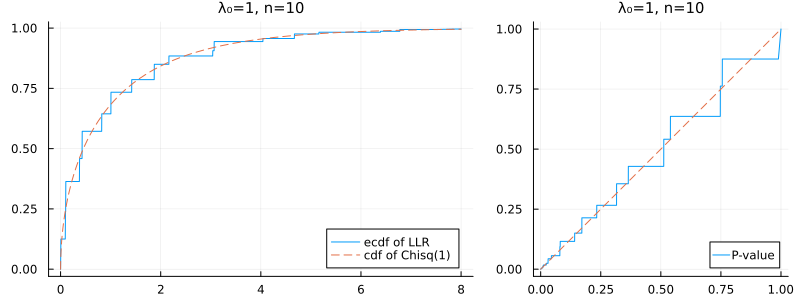

In [3]:
plot_ecdf_LLR(; λ₀ = 1, n = 10)

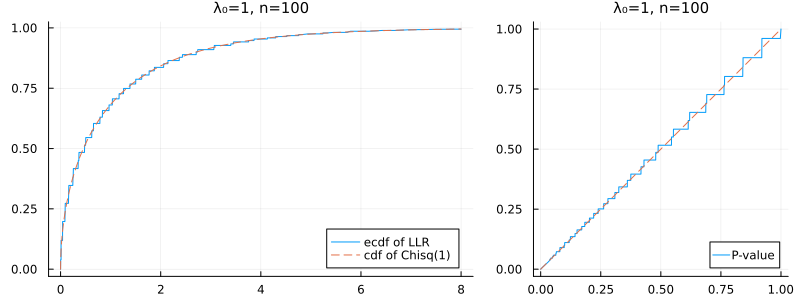

In [4]:
plot_ecdf_LLR(; λ₀ = 1, n = 100)

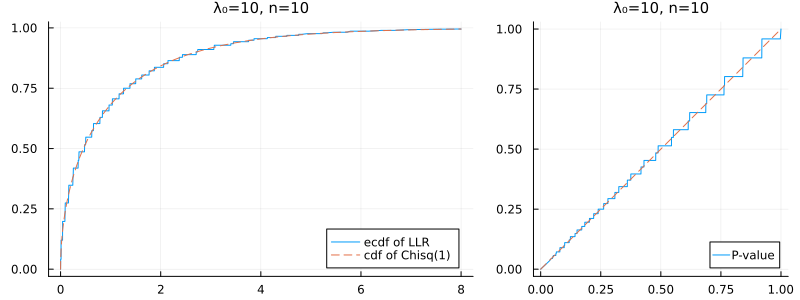

In [5]:
plot_ecdf_LLR(; λ₀ = 10, n = 10)

グラフの上では, $n\lambda_0 = 100$ のとき, 統計モデル0に従ってデータがランダムに生成されているとき, 対数尤度比 $\op{LLR}$ が従う分布は自由度1のχ²分布 $\op{Chisq}(1)$ でよく近似されることが分かった.  (近似を累積分布函数の比較で確認した.)

### Bayes因子

__事前分布:__ 統計モデル1(パラメータが固定されていないPoisson分布モデル)のパラメータ $\lambda > 0$ に関する事前分布 $\varphi(\lambda)$ を考える.

統計モデル0ではパラメータ $\lambda$ が $\lambda_0$ に固定されているので, 事前分布は自明なものしかないことに注意せよ.

__周辺尤度:__ 与えられたデータの数値 $k=(k_1,\ldots,k_n)$ に関する統計モデル1＋事前分布 $\varphi(\lambda)$ の周辺尤度 $Z_1$ が次のように定義される:

$$
Z_1 = \int_0^\infty P(k|\lambda)\varphi(\lambda)\,d\lambda.
$$

統計モデル0の周辺尤度 $Z_0$ は尤度に等しい:

$$
Z_0 = P(k|\lambda_0).
$$

一般に尤度は「データの数値へのモデルの相性の良さもしくは適藤度の指標の1つ」として利用できる.  周辺尤度も同様である.

周辺尤度の比をBayes因子と呼び, 次のように書くことにする:

$$
\op{BF} = \frac{Z_1}{Z_0}.
$$

Bayes因子 $\op{BF}$ が大きいほど, 統計モデル1＋事前分布の方が統計モデル0よりもデータによく適合していると解釈可能である.

Beyes因子は統計モデルの尤度函数 $\lambda\mapsto P(k|\lambda)$ と事前分布 $\varphi(\lambda)$ だけで決まり, 尤度函数に $\lambda$ によらない正の定数をかけたものを尤度函数の代わりに使ってBayes因子を定義し直してもBayes因子は不変である.

### 対数尤度比とBayes因子の関係

対数尤度比

$$
\op{LLR} = 2\log\frac{P(k|\kbar)}{P(k|\lambda_0)}, \quad
P(k|\lambda) = \frac{e^{-n\lambda}\lambda^{n\kbar}}{k_1!\cdots k_n!}, \quad
\kbar = \frac{1}{n}\sum_{i=1}^n k_i
$$

と

$$
\op{BF} = \frac{Z_1}{Z_0} =
\int_0^\infty \frac{P(k|\lambda)}{P(k|\lambda_0)}\varphi(\lambda)\,d\lambda
$$

の $n$ が大きなときの関係をLaplace近似によって示そう.

以上の設定の下で, 

$$
\frac{P(k|\lambda)}{P(k|\lambda_0)} =
e^{-n(\lambda-\lambda_0)}\left(\frac{\lambda}{\lambda_0}\right)^{n\kbar} =
\exp\left(n\left(\kbar\log\frac{\lambda}{\lambda_0} - (\lambda-\lambda_0)\right)\right).
$$

なので, 

$$
f(\lambda) := 2\log\frac{P(k|\lambda)}{P(k|\lambda_0)} =
2n\left(\kbar\log\frac{\lambda}{\lambda_0} - (\lambda-\lambda_0)\right)
$$

ゆえに, 対数尤度比は次のように書き直される:

$$
\begin{aligned}
\op{LLR} = f(\kbar) =
2n\left(\kbar\log\frac{\kbar}{\lambda_0} - (\kbar - \lambda_0)\right).
\end{aligned}
$$

対数尤度比 $\op{LLR}$ は $f(\lambda)$ の最大値になっている.

$$
f'(\lambda) = 2n\left(\frac{\kbar}{\lambda} - 1\right), \quad
f'(\kbar) = 0, \quad
f''(\lambda) = -2n\frac{\kbar}{\lambda^2}, \quad
f''(\kbar) = -2n\frac{1}{\kbar}
$$

なので, $\lambda$ が $\kbar$ に近いとき, $f(\lambda)$ の $\lambda=\kbar$ でのTaylor展開によって, 

$$
f(\lambda) \approx \op{LLR} - 2\frac{(\lambda-\kbar)^2}{2\kbar/n}.
$$

このとき,

$$
\frac{P(k|\lambda)}{P(k|\lambda_0)} = e^{2f(\lambda)}
\approx e^{\op{LLR}/2}e^{-(\lambda-\kbar)^2/(\kbar/n)}.
$$

したがって, $n$ が大きなとき, 次のLaplace近似が得られる:

$$
\op{BF}
\approx e^{\op{LLR}/2} \int e^{-(\lambda-\kbar)^2/(\kbar/n)}\varphi(\lambda)\,d\lambda
\approx e^{\op{LLR}/2} \varphi(\kbar) \sqrt{\frac{2\pi\kbar}{n}}.
$$

実際に数値的に確認すると, この近似は非常に良い近似になり易い.

さらに, $\kbar$ が $\lambda_0$ に近いならば次の近似も成立する(近似は粗くなる):

$$
\op{BF}
\approx e^{\op{LLR}/2} \varphi(\lambda_0) \sqrt{\frac{2\pi\lambda_0}{n}}.
$$

すなわち,

$$
2\log\op{BF}
\approx \op{LLR} - \log n + \log(2\pi\lambda_0) + 2\log\varphi(\lambda_0).
$$

これが欲しい結果である.

__注意:__ この近似の右辺における $\op{LLR} - \log n$ の部分は統計モデル0のBIC(Bayes情報量基準)から統計モデル1のBICを引いた結果に等しい.  BICによるモデル選択は上の近似の $n$ に関する定数項 $\log(2\pi\lambda_0) + 2\log\varphi(\lambda_0)$ を無視するさらに粗い近似を利用していると考えられる.

### 対数尤度比検定のP値とBayes因子の関係

$C > 0$, $0\le\alpha\le 1$ と仮定する.

前節の近似

$$
2\log\op{BF}
\approx \op{LLR} - \log n + \log(2\pi\lambda_0) + 2\log\varphi(\lambda_0).
$$

を仮定し,  近似的に同値であることも $\iff$ と書くと, 

$$
\begin{aligned}
\op{BF} > C &\iff 2\log\op{BF} > 2\log C
\\ &\iff
\op{LLR} > 2\log C + \log n - \log(2\pi\lambda_0) - 2\log\varphi(\lambda_0)
\\ &\iff
\cdf(\op{Chisq}(1), \op{LLR}) >
\cdf(\op{Chisq}(1), 2\log C + \log n - \log(2\pi\lambda_0) - 2\log\varphi(\lambda_0))
\\ &\iff
\pvalue(k|\lambda_0) <
1 - \cdf(\op{Chisq}(1), 2\log C + \log n - \log(2\pi\lambda_0) - 2\log\varphi(\lambda_0))
\end{aligned}
$$

なので,

$$
\alpha = 1 - \cdf(\op{Chisq}(1), 2\log C + \log n - \log(2\pi\lambda_0) - 2\log\varphi(\lambda_0))
$$

すなわち

$$
2\log C =
\quantile(\op{Chisq}(1), 1 - \alpha) - \log n + \log(2\pi\lambda_0) + 2\log\varphi(\lambda_0)
$$

とおくと($\quantile(D, p)$ は分布 $D$ の分位点函数 = $\cdf$ の逆函数), 近似的に

$$
\op{BF} > C \iff \pvalue(k|\lambda_0) < \alpha.
$$

以下ではこの近似的な同値性を数値的に確認しよう.

### 数値的な確認

計算を簡単にするために事前分布として共役事前分布のガンマ分布 $\op{Gamma}(\alpha_0, 1/\tau_0)$ を採用しよう:

$$
\varphi(\lambda) = \frac{\tau_0^{\alpha_0}}{\Gamma(\alpha_0)}\lambda^{\alpha_0-1}e^{-\tau_0\lambda}.
$$

例えば $\alpha_0 = 1$, $\tau_0 = 1$ のとき, この事前分布は期待値 $1$ の指数分布になる.

このとき, 簡単な積分計算によって, Bayes因子は次のように書けることがわかる:

$$
\op{BF} =
\frac{1}{\lambda_0^{n\kbar}e^{-n\lambda_0}}
\frac{\tau_0^{\alpha_0}}{\Gamma(\alpha_0)}
\frac{\Gamma(\alpha_0+n\kbar)}{(\tau_0 + n)^{\alpha_0+n\kbar}}.
$$

すなわち

$$
\begin{aligned}
2\log\op{BF}
&=
2(\log\Gamma(\alpha_0+n\kbar) - (\alpha_0+n\kbar)\log(\tau_0 + n))
-2(\log\Gamma(\alpha_0) - \alpha_0\log\tau_0)
\\ &\,+
2n(\lambda_0 - \kbar\log\lambda_0).
\end{aligned}
$$

この公式を使って, 対数尤度比とBayes因子を比較しよう.

In [6]:
function C2alpha(C, n; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    ccdf(Chisq(1), 2log(C) + log(n) - log(2π*λ₀) - 2logpdf(Gamma(α₀, 1/τ₀), λ₀))
end

function alpha2C(α, n; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    twologC = quantile(Chisq(1), 1-α) - log(n) + log(2π*λ₀) + 2logpdf(Gamma(α₀, 1/τ₀), λ₀)
    exp(twologC/2)
end

alpha2C (generic function with 1 method)

In [7]:
@show alpha2C(C2alpha(10, 100), 100) ≈ 10
@show C2alpha(alpha2C(0.1, 100), 100) ≈ 0.1;

alpha2C(C2alpha(10, 100), 100) ≈ 10 = true
C2alpha(alpha2C(0.1, 100), 100) ≈ 0.1 = true


In [8]:
function plot_C2alpha(C; n=10:1000, λ₀=1, α₀=1, τ₀=α₀/λ₀, kwargs...)
    plot(n, n -> C2alpha(C, n; λ₀, α₀, τ₀); label="")
    plot!(ylim=(0, C2alpha(C, n[begin]; λ₀, α₀, τ₀)))
    plot!(xguide="n", yguide="α")
    title!("α corresponding to C=$C, λ₀=$λ₀, α₀=$α₀, τ₀=$τ₀")
    plot!(; kwargs...)
end

plot_C2alpha (generic function with 1 method)

$\op{BF} > C$ に対応する有意水準 $\alpha$ は $n$ の単調減少函数になる.

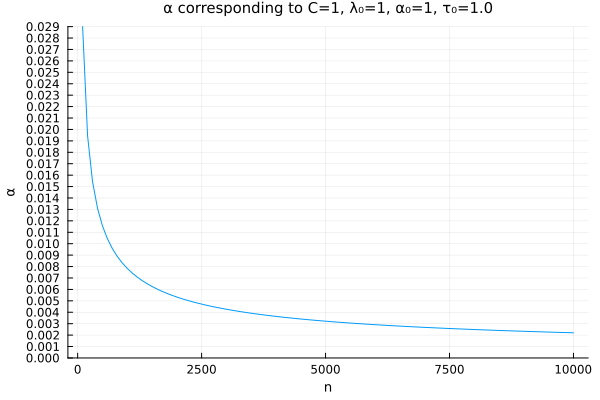

In [9]:
plot_C2alpha(1; n=10^2:10^2:10^4, ytick=0:0.001:1)

In [10]:
2ccdf(Normal(), 2) # significance level of 2σ

0.04550026389635841

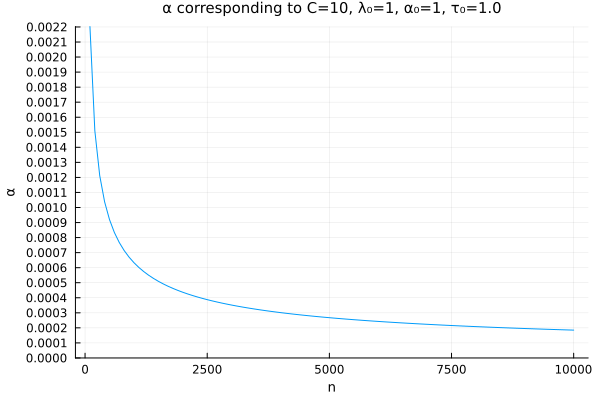

In [11]:
plot_C2alpha(10; n=100:10^2:10^4, ytick=0:0.0001:1)

In [12]:
2ccdf(Normal(), 3) # significance level of 3σ

0.002699796063260186

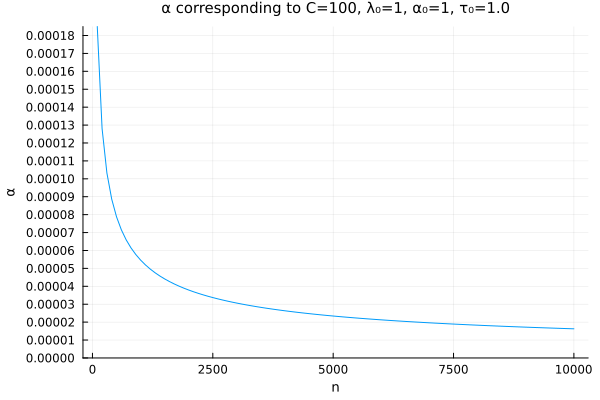

In [13]:
plot_C2alpha(100; n=100:10^2:10^4, ytick=0:0.00001:1)

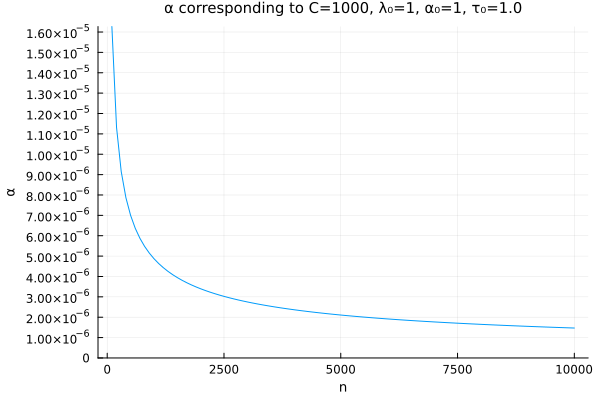

In [14]:
plot_C2alpha(1000; n=100:10^2:10^4, ytick=0:1e-6:1)

In [15]:
2ccdf(Normal(), 4) # significance level of 4σ

6.334248366623977e-5

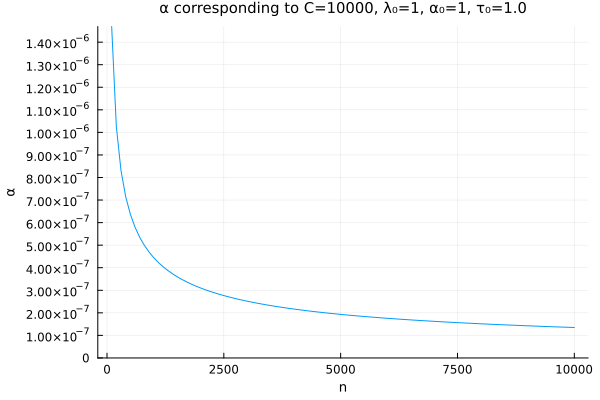

In [16]:
plot_C2alpha(10000; n=10^2:10^2:10^4, ytick=0:1e-7:1)

In [17]:
2ccdf(Normal(), 5) # significance level of 5σ

5.733031437583873e-7

$n \le 10^4$ では, $5\sigma$ に対応する小さな有意水準を実現するためには非常に大きな $C$ に関する $\op{BF} > C$ という条件を考える必要がある. 

In [18]:
logZ_Gamma(α, τ) = loggamma(α) - α*log(τ)

function twologBF(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    n, k̄ = length(k), mean(k)
    2logZ_Gamma(α₀+n*k̄, τ₀+n) - 2logZ_Gamma(α₀, τ₀) + 2n*(λ₀ - k̄*log(λ₀))
end

function twologBF_approx(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    n = length(k)
    loglikrat(k; λ₀) - log(n) + log(2π*λ₀) + 2logpdf(Gamma(α₀, 1/τ₀), λ₀)
end

function twologBF_approx0(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    n, k̄ = length(k), mean(k)
    loglikrat(k; λ₀) - log(n) + log(2π*k̄) + 2log(pdf(Gamma(α₀, 1/τ₀), k̄))
end

twologBF_approx0 (generic function with 1 method)

In [19]:
k = rand(Poisson(1), 1000)
α₀, τ₀ = 1, 1e-2
@show twologBF(k; α₀, τ₀)
@show twologBF_approx0(k; α₀, τ₀)
@show twologBF_approx(k; α₀, τ₀);

twologBF(k; α₀, τ₀) = -13.255969504946279
twologBF_approx0(k; α₀, τ₀) = -13.256111106959546
twologBF_approx(k; α₀, τ₀) = -13.286969774018917


In [20]:
function sim_BF(; n=100, λ₀=1, α₀=1, τ₀=α₀/λ₀, L=10^5)
    TLBF = Vector{Float64}(undef, L)
    TLBF_approx0 = Vector{Float64}(undef, L)
    TLBF_approx = Vector{Float64}(undef, L)
    tmp = [Vector{Int}(undef, n) for _ in 1:Threads.nthreads()]
    model0 = Poisson(λ₀)
    Threads.@threads for i in 1:L
        K = rand!(model0, tmp[Threads.threadid()])
        TLBF[i] = twologBF(K; λ₀, α₀, τ₀)
        TLBF_approx0[i] = twologBF_approx0(K; λ₀, α₀, τ₀)
        TLBF_approx[i] = twologBF_approx(K; λ₀, α₀, τ₀)
    end
    _TLBF = ecdf(TLBF)
    _TLBF_approx0 = ecdf(TLBF_approx0)
    _TLBF_approx = ecdf(TLBF_approx)
    ecdf_TLBF(x) = _TLBF(x)
    ecdf_TLBF_approx0(x) = _TLBF_approx0(x)
    ecdf_TLBF_approx(x) = _TLBF_approx(x)
    (; ecdf_TLBF, ecdf_TLBF_approx0, ecdf_TLBF_approx, TLBF, TLBF_approx0, TLBF_approx)
end

function plot_BF(; n=100, λ₀=1, α₀=1, τ₀=α₀/λ₀, L=10^4)
    (; ecdf_TLBF, ecdf_TLBF_approx0, ecdf_TLBF_approx, TLBF, TLBF_approx0, TLBF_approx) =
        sim_BF(; n, λ₀, α₀, τ₀, L)
    lim = collect(extrema(TLBF))
    
    P1 = scatter(TLBF, TLBF_approx0; ms=1, ma=0.7, msw=0, label="")
    plot!(lim, lim; label="", ls=:dash, lw=0.5)
    plot!(xguide="2log(BF)", yguide="approx0")
    
    P2 = scatter(TLBF, TLBF_approx; ms=1.5, ma=0.7, msw=0, label="")
    plot!(lim, lim; label="", ls=:dash, lw=0.7)
    plot!(xguide="2log(BF)", yguide="approx")
    
    plot(P1, P2; size=(600, 300))
    plot!(plot_title="n=$n, λ₀=$λ₀, α₀=$α₀, τ₀=$τ₀")
end

plot_BF (generic function with 1 method)

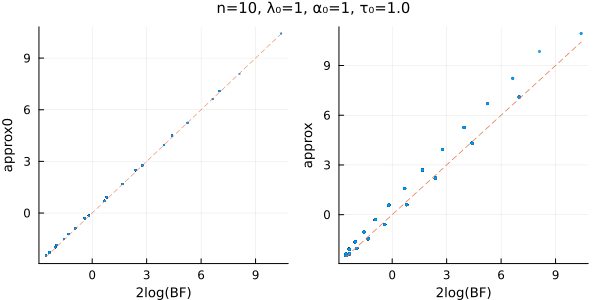

In [21]:
plot_BF(n=10)

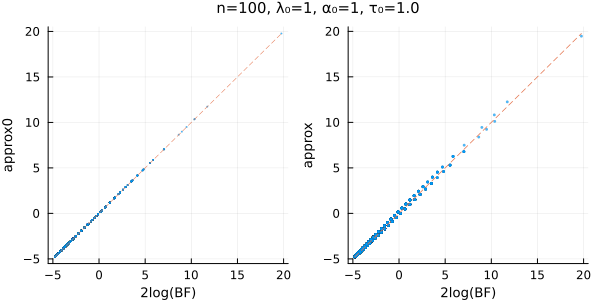

In [22]:
plot_BF(n=100)

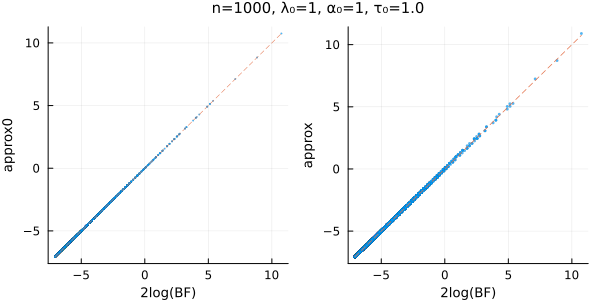

In [23]:
plot_BF(n=1000)

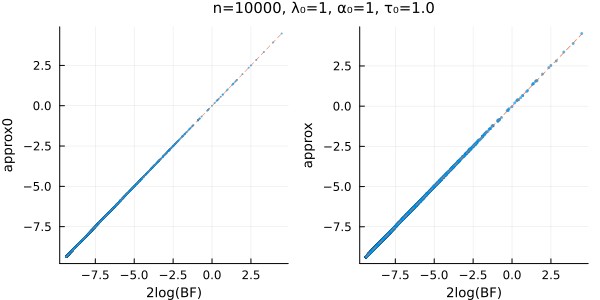

In [24]:
plot_BF(n=10000)

In [25]:
function loglikrat_approx(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    n = length(k)
    twologBF(k; λ₀, α₀, τ₀) + log(n) - log(2π*λ₀) - 2logpdf(Gamma(α₀, 1/τ₀), λ₀)
end

function loglikrat_approx0(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    n, k̄ = length(k), mean(k)
    twologBF(k; λ₀, α₀, τ₀) + log(n) - log(2π*k̄) - 2logpdf(Gamma(α₀, 1/τ₀), k̄)
end

function pvalue_approx(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    LLR = loglikrat_approx(k; λ₀)
    ccdf(Chisq(1), LLR)
end

function pvalue_approx0(k; λ₀=1, α₀=1, τ₀=α₀/λ₀)
    LLR = loglikrat_approx0(k; λ₀)
    ccdf(Chisq(1), LLR)
end

pvalue_approx0 (generic function with 1 method)

In [26]:
k = rand(Poisson(1), 1000)
λ₀, α₀, τ₀ = 1, 1, 1e-2
@show pvalue(k; λ₀)
@show pvalue_approx0(k; λ₀, α₀, τ₀)
@show pvalue_approx(k; λ₀, α₀, τ₀);

pvalue(k; λ₀) = 0.6816517754127722
pvalue_approx0(k; λ₀, α₀, τ₀) = 0.6823878712168284
pvalue_approx(k; λ₀, α₀, τ₀) = 0.6943970472851498


In [27]:
function sim_pval(; n=100, λ₀=1, α₀=1, τ₀=α₀/λ₀, L=10^5)
    pval = Vector{Float64}(undef, L)
    pval_approx0 = Vector{Float64}(undef, L)
    pval_approx = Vector{Float64}(undef, L)
    tmp = [Vector{Int}(undef, n) for _ in 1:Threads.nthreads()]
    model0 = Poisson(λ₀)
    Threads.@threads for i in 1:L
        K = rand!(model0, tmp[Threads.threadid()])
        pval[i] = pvalue(K; λ₀)
        pval_approx0[i] = pvalue_approx0(K; λ₀, α₀, τ₀)
        pval_approx[i] = pvalue_approx(K; λ₀, α₀, τ₀)
    end
    _pval = ecdf(pval)
    _pval_approx0 = ecdf(pval_approx0)
    _pval_approx = ecdf(pval_approx)
    ecdf_pval(x) = _pval(x)
    ecdf_pval_approx0(x) = _pval_approx0(x)
    ecdf_pval_approx(x) = _pval_approx(x)
    (; ecdf_pval, ecdf_pval_approx0, ecdf_pval_approx, pval, pval_approx0, pval_approx)
end

function plot_pval(; n=100, λ₀=1, α₀=1, τ₀=α₀/λ₀, L=10^4)
    (; ecdf_pval, ecdf_pval_approx0, ecdf_pval_approx, pval, pval_approx0, pval_approx) =
        sim_pval(; n, λ₀, α₀, τ₀, L)
    lim = [0.0, 1.0]
    
    P1 = scatter(pval, pval_approx0; ms=1, ma=0.7, msw=0, label="")
    plot!(lim, lim; label="", ls=:dash, lw=0.5)
    plot!(xguide="log likelihood ratio P-value", yguide="approx0")
    
    P2 = scatter(pval, pval_approx; ms=1.5, ma=0.7, msw=0, label="")
    plot!(lim, lim; label="", ls=:dash, lw=0.7)
    plot!(xguide="log likelihood ratio P-value", yguide="approx")
    
    plot(P1, P2; size=(600, 300))
    plot!(plot_title="n=$n, λ₀=$λ₀, α₀=$α₀, τ₀=$τ₀")
end

plot_pval (generic function with 1 method)

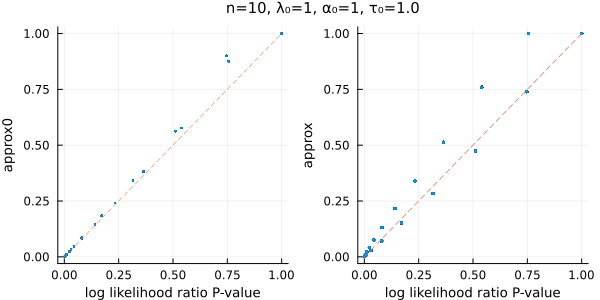

In [28]:
plot_pval(n=10)

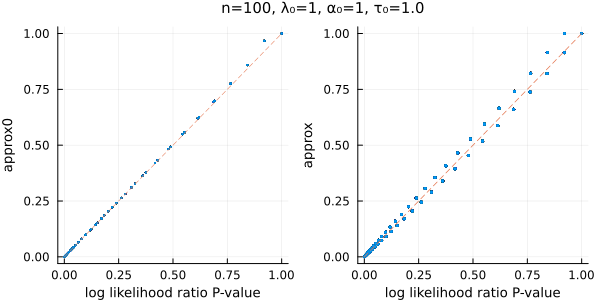

In [29]:
plot_pval(n=100)

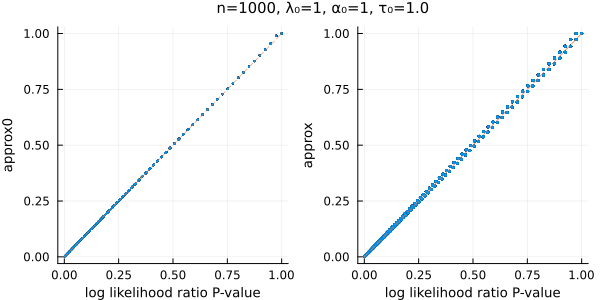

In [30]:
plot_pval(n=1000)

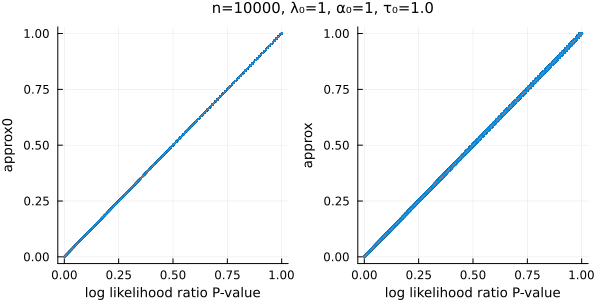

In [31]:
plot_pval(n=10000)